In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, os.environ['KZ_CODE'])
from kz_code import quantile

from library.ccba import nmf_and_score
from library.visualize import plot_nmf_result, plot_nmf_scores
%matplotlib inline

<17:42:08.571770> Checking dependencies ...
<17:42:08.574132> Using the following packages:
<17:42:08.575909> 	matplotlib v1.5.1
<17:42:08.575928> 	numpy v1.10.4
<17:42:08.575937> 	pandas v0.18.0
<17:42:08.575958> 	rpy2 v2.7.9
<17:42:08.575967> 	scikit-learn v0.17.1
<17:42:08.575974> 	scipy v0.17.0
<17:42:08.575981> 	seaborn v0.7.0


gene_x_sample_df.shape: (22944, 211)


[<matplotlib.text.Text at 0x11a6ed5f8>, <matplotlib.text.Text at 0x11a6dc358>]

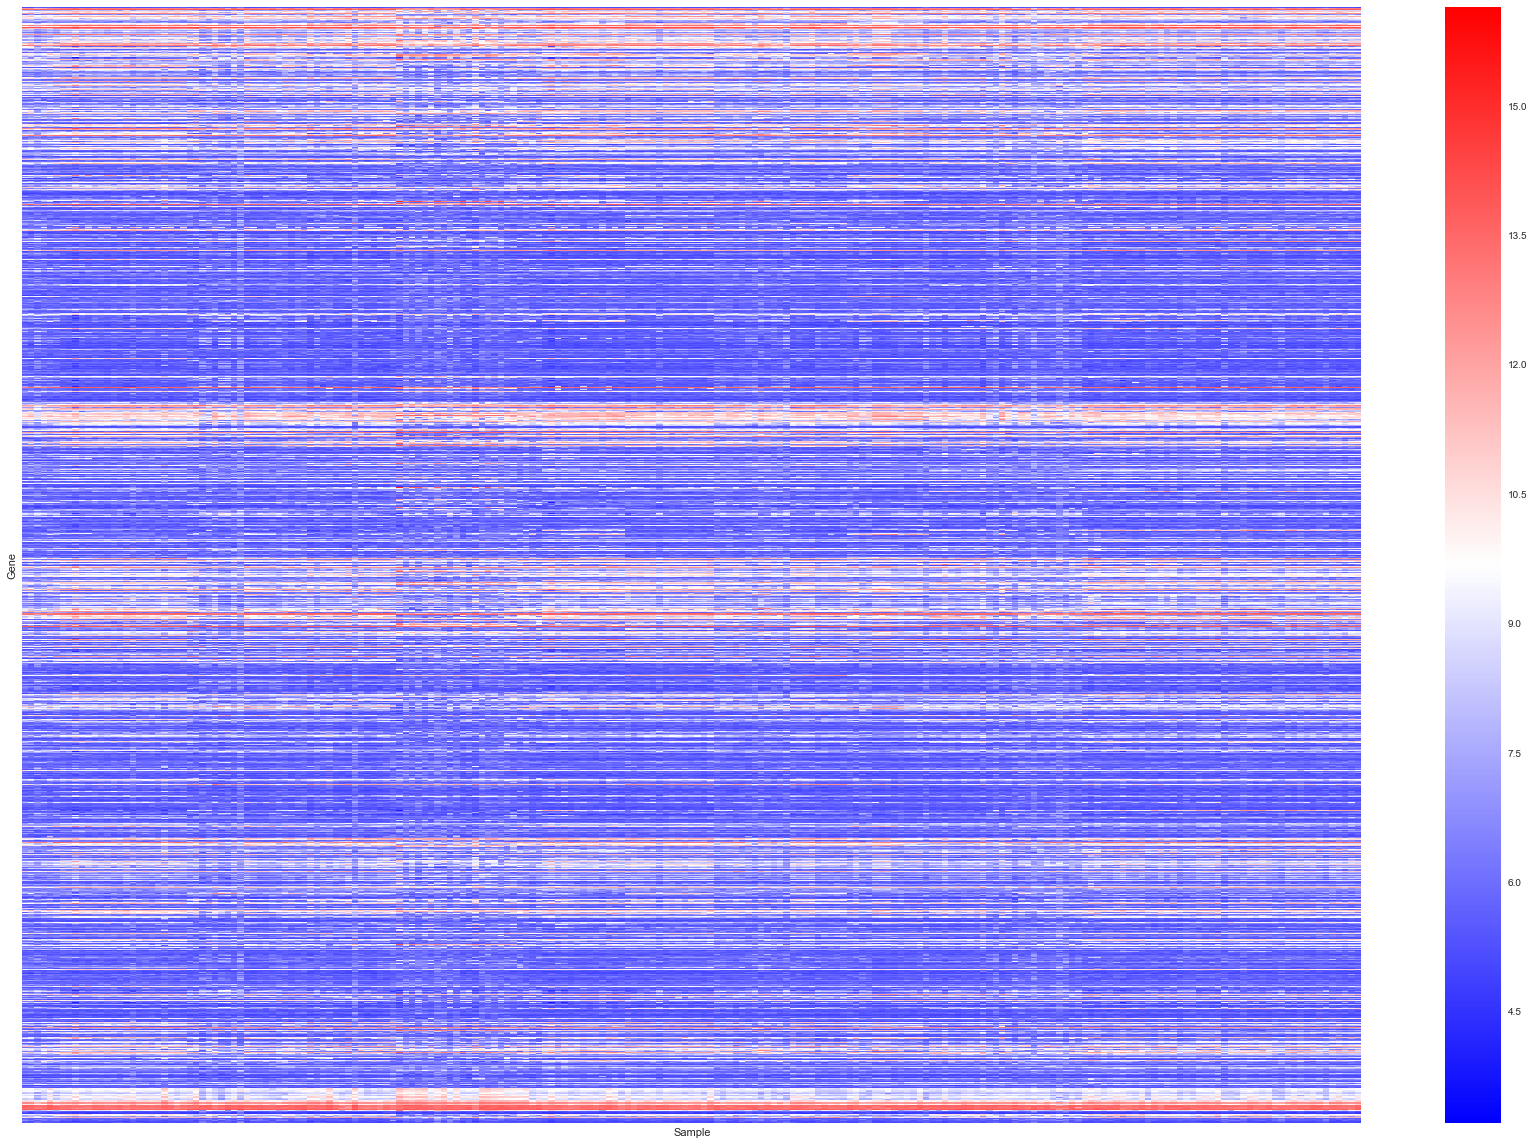

In [2]:
# Read gene expression matrix
gene_x_sample_df = pd.read_csv('data/GES24759/GSE24759_series_matrix.txt', sep='\t', comment='!', index_col=0)
print('gene_x_sample_df.shape: {}'.format(gene_x_sample_df.shape))

plt.figure(figsize=(30, 20))
ax = sns.heatmap(gene_x_sample_df, cmap='bwr', xticklabels=False, yticklabels=False)
ax.set(xlabel='Sample', ylabel='Gene')

In [3]:
# NMF and select k
ks = [5, 6]  # Ks from which to select k
nmf_results, scores = nmf_and_score(gene_x_sample_df, ks, method='cophenetic_correlation')

<17:35:37.164619> Computing clustering score for k=5 using method cophenetic_correlation ...
<17:35:37.164665> Running NMF #0 (total number of assignments=20) ...
<17:35:37.164676> Perfomring NMF with k=5 ...
<17:35:38.410121> Running NMF #1 (total number of assignments=20) ...
<17:35:38.410194> Perfomring NMF with k=5 ...
<17:35:39.663102> Running NMF #2 (total number of assignments=20) ...
<17:35:39.663172> Perfomring NMF with k=5 ...
<17:35:40.931438> Running NMF #3 (total number of assignments=20) ...
<17:35:40.931509> Perfomring NMF with k=5 ...
<17:35:42.181259> Running NMF #4 (total number of assignments=20) ...
<17:35:42.181333> Perfomring NMF with k=5 ...
<17:35:43.824394> Running NMF #5 (total number of assignments=20) ...
<17:35:43.824502> Perfomring NMF with k=5 ...
<17:35:47.148103> Running NMF #6 (total number of assignments=20) ...
<17:35:47.148220> Perfomring NMF with k=5 ...
<17:35:50.699721> Running NMF #7 (total number of assignments=20) ...
<17:35:50.699829> Perfomr

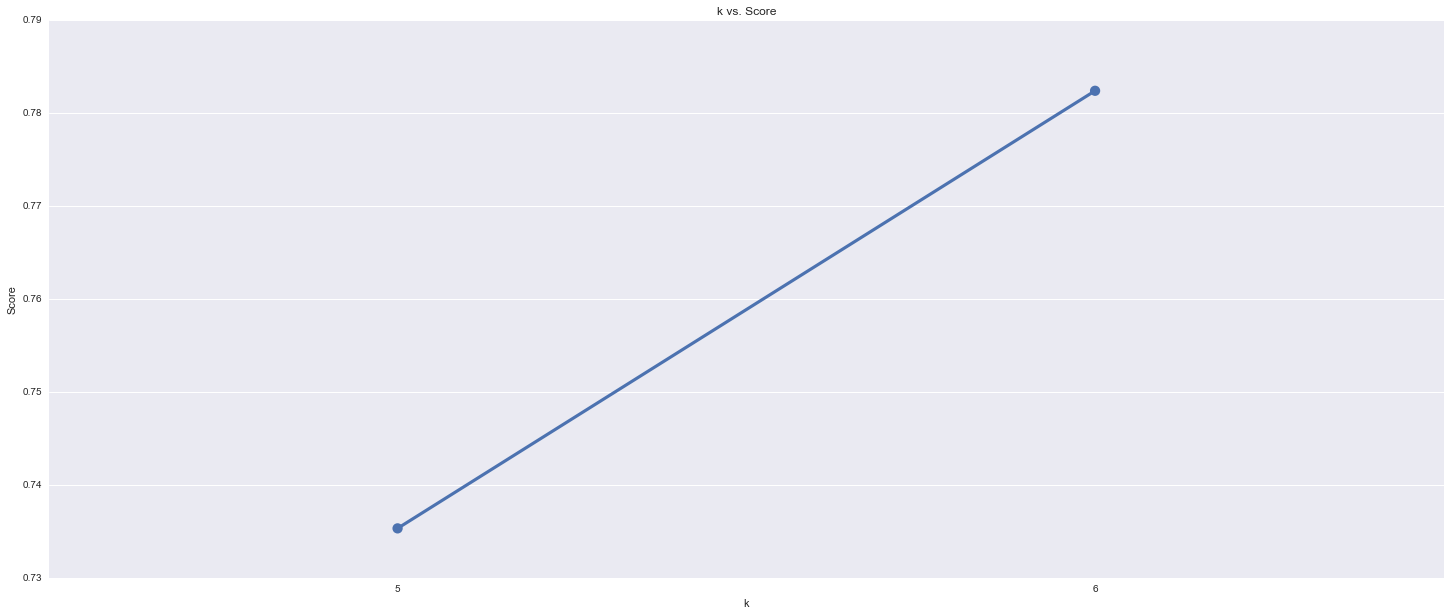

In [4]:
plot_nmf_scores(scores)

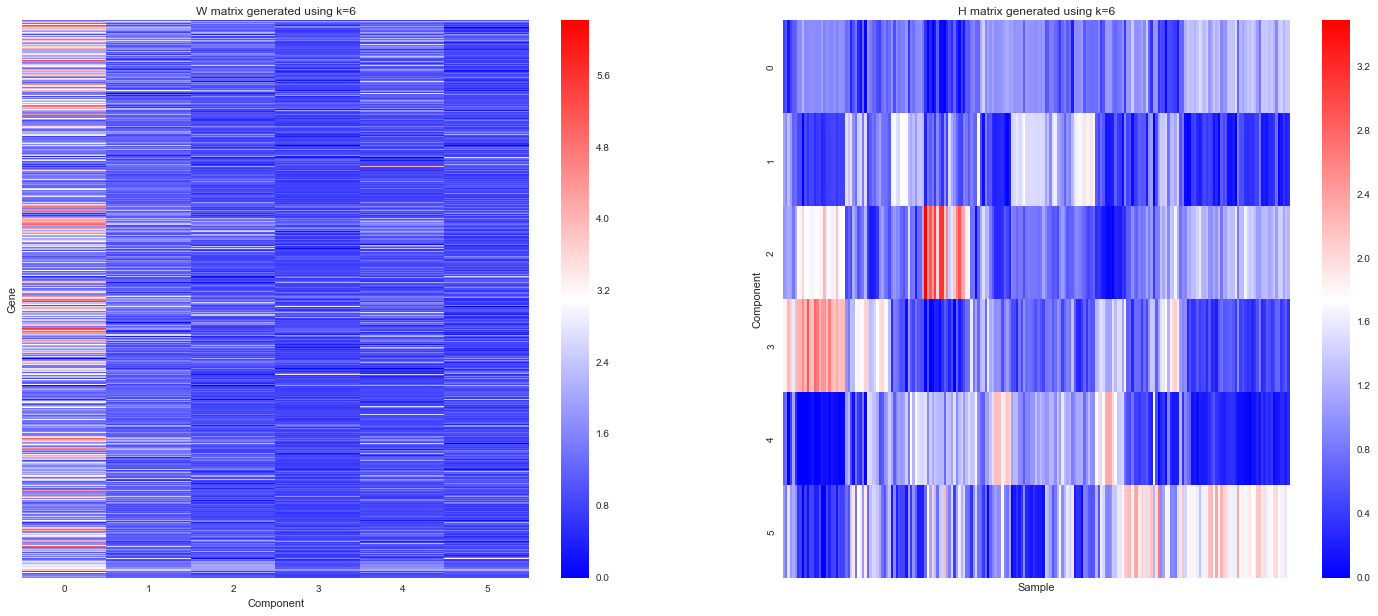

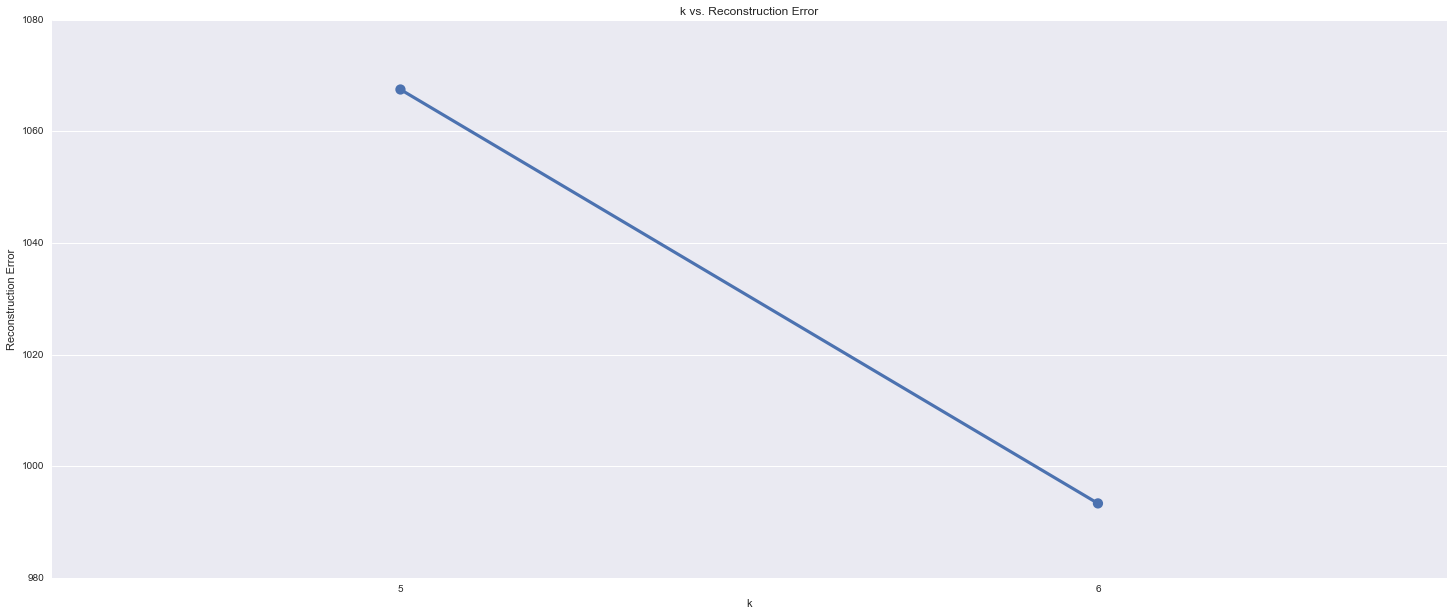

In [5]:
# Plot W and H matrices
k = 6
plot_nmf_result(nmf_results, 6)

In [6]:
# Get gene information
with open('data/GES24759/GSE24759_family.soft') as f:
    gene_info = {}
    parse_errors = {}
    gene_symbol_errors = {}
    parse = False
    for i, line in enumerate(f.readlines()):
        line = line.strip()
        if not parse:
            if line == '!platform_table_begin':
                parse = True
                print('Start parsing at line {}'.format(i))
        else:
            if line == '!platform_table_end':
                print('Stop parsing at line {}'.format(i))
                parse = False
                break
            else:
                split = line.split('\t')
                try:
                    if (split[8] == '' or split[8] =='NA'):
                        gene_symbol_errors[split[0]] = line
                        continue
                    elif split[0] in gene_info:
                        print('Duplicate at {}'.format(split[0]))
                    else:
                        gene_info[split[0]] = {'gene_title':split[7],
                                               'gene_symbol':split[8].split(' /// '),
                                               'entrez_gene':split[9],
                                               'refseq':split[10].split(' /// ')}
                except:
                    parse_errors[split[0]] = line
    print('Parse error: {}'.format(len(parse_errors)))
    print('Gene symbol error {}'.format(len(gene_symbol_errors)))

Start parsing at line 277
Stop parsing at line 23223
Parse error: 1173
Gene symbol error 741


In [11]:
# TODO: figure out why the number of passing values are the same for other col in W
top_genes = {}  # dictionary(key: component; value: top genes)

percentile = 0.99
for i in range(nmf_results[k]['W'].shape[1]):
    name = 'k{}c{}'.format(k, i)
    print('Analyzing {} ...'.format(name))
    
    top_genes[name] = set()
    
    col = nmf_results[k]['W'][:, i]
    threshold = quantile(col, 100/((1-percentile)*100))[-1]
    indices_passing_threshold = np.nonzero(np.greater_equal(col, threshold)*col)[0]
    print('{} genes above {} percentile threshold.'.format(len(indices_passing_threshold), percentile*100))

    for gene in gene_x_sample_df.index[indices_passing_threshold]:
        if gene in gene_info:
            top_genes[name].update(set(gene_info[gene]['gene_symbol']))
        elif gene in parse_errors:
            print('Parse error at {}'.format(gene))
        elif gene in gene_symbol_errors:
            print('Gene symbol error at {}'.format(gene))
        else:
            print('Unknown error at {}'.format(gene))

Analyzing k6c0 ...
229 genes above 99.0 percentile threshold.
Parse error at 212560_at
Parse error at 212764_at
Parse error at 213158_at
Parse error at 215450_at
Parse error at 217554_at
Gene symbol error at HC-AL049987_at
Gene symbol error at HC-L41887_at
Gene symbol error at HC-M37033_at
Analyzing k6c1 ...
229 genes above 99.0 percentile threshold.
Gene symbol error at 212044_s_at
Parse error at 216246_at
Gene symbol error at HC-X76732_at
Analyzing k6c2 ...
229 genes above 99.0 percentile threshold.
Gene symbol error at HC-D87127_at
Analyzing k6c3 ...
229 genes above 99.0 percentile threshold.
Parse error at 213839_at
Parse error at 214836_x_at
Parse error at 215176_x_at
Parse error at 217257_at
Gene symbol error at HC-M37033_at
Analyzing k6c4 ...
229 genes above 99.0 percentile threshold.
Parse error at 213817_at
Analyzing k6c5 ...
229 genes above 99.0 percentile threshold.
Parse error at 208192_at
Parse error at 208529_at
Parse error at 211617_at
Parse error at 214809_at
Parse erro

In [12]:
for k, v in top_genes.items():
    print('\n\n*** {} ***'.format(k))
    for g in v:
        print('{}'.format(g))



*** k6c0 ***
ARHGEF6
NCBP2
RPL22
BTN3A2
TRBV3-1
ANGEL2
VDP
RYK
PTBP2
FNDC3A
KIAA0179
ECOP
CBWD3
ZFP36L2
MGC8902
ITGA6
RPL13
H3F3B
DPH5
FUS
C14orf138
FOXO1A
BTN3A3
TRBC1
LYRIC
ITPKB
IFI16
BTN3A1
FNBP1
AG1
CD52
VPS13C
DYRK2
MKL2
ATM
TORC3
LOC200030
RPL3
DDX50
SLC38A1
TNPO1
KIAA1076
MTMR1
TRIB2
GOLGA8B
EP400
SMCHD1
RPS19
TBC1D4
FNBP4
ZMYND11
SMAD3
FLJ20485
ARHGEF3
GMFG
DDB2
PORIMIN
TNFAIP8
ADD3
MGA
PRKD3
POLS
ATR
CUGBP2
RAPGEF6
GLTSCR2
PSIP1
GTPBP3
AE01
TARBP1
FLJ20719
SACS
LOC93349
TGFBR2
ZNF292
NPM1
BUB3
SLC7A6
RANBP2L1
IFI44
C6orf82
NARG1L
TRBV21-1
THUMPD1
ACSL5
BCL2
ABCC1
ARHGAP15
ZNF262
SR140
ANKRD10
IL2RG
ZNF609
CYLD
RBM34
CENTD1
SFRS5
SNRPA1
LDHB
RPS14
PDE4D
TTC3
COIL
ZNF395
GOLGA8A
CD53
AHNAK
FUBP1
MYCBP2
MGC3265
PIK3C2B
NOTCH2
LHX3
FBL
TRBV5-4
Septin 6
RABL2B
GPR171
ZFP36L1
SHQ1
TARDBP
ABLIM1
MRPS6
IPO7
SFRS11
C6orf111
KIAA0528
MDFIC
GARNL1
MDN1
TES
CCND2
DOCK10
CBFB
CBWD2
SELL
LEF1
GAPDS
RUNX1
FLJ20436
DC36
C6orf48
HNRPH3
RPS18
RASGRP1
DDX47
SFRS7
LOC375258
MACF1
PRDM2
NKTR
HN